Load the trades we made in our own strategy

In [1]:
import pandas as pd
df: pd.DataFrame = pd.read_csv("../test/BACK_Test_2025-12-22_084409_start_04-10-2024_end_04-18-2024_trade_reports.csv")

Load the market data of the asset we were trading when we were running our strategy, based on last trade price. 

Parsed 82453 trades from 8 files.


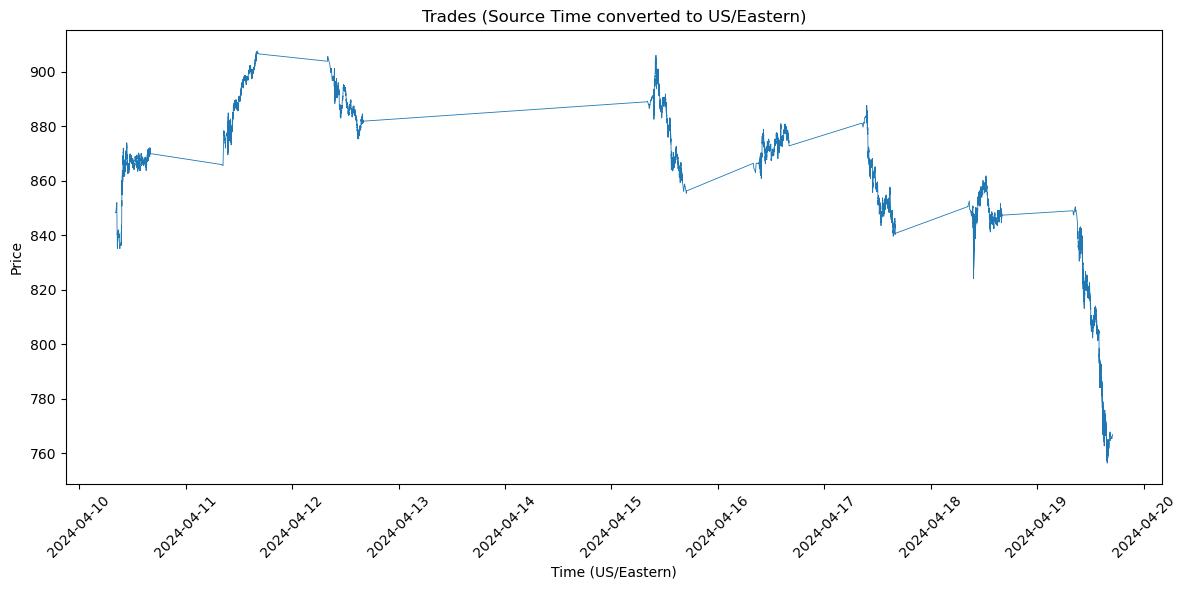

In [2]:
from pathlib import Path
from zoneinfo import ZoneInfo
import pandas as pd
import matplotlib.pyplot as plt

# Directory containing market data text files
DATA_DIR = Path.home() / "market_data"

records = []
for path in sorted(DATA_DIR.glob("*.txt")):
    with path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(",")
            # Expect at least: collection_time, source_time, seq, tick_type, mkt, price, size
            if len(parts) < 7:
                continue
            tick_type = parts[3]
            if tick_type != "T":  # keep trades only
                continue
            try:
                # Source time is column 2 (index 1), already UTC
                src_time = pd.to_datetime(parts[1], utc=True)
                price = float(parts[5])
            except Exception:
                continue
            records.append((src_time, price, path.name))

trade_df = pd.DataFrame(records, columns=["source_time_utc", "price", "file"])

if trade_df.empty:
    raise ValueError("No trade rows parsed from market_data/*.txt")

# Convert to US/Eastern with DST handling via zoneinfo
trade_df["time_et"] = trade_df["source_time_utc"].dt.tz_convert(ZoneInfo("America/New_York"))
trade_df = trade_df.sort_values("time_et")

print(f"Parsed {len(trade_df)} trades from {trade_df['file'].nunique()} files.")

# Plot time vs price
plt.figure(figsize=(12, 6))
plt.plot(trade_df["time_et"], trade_df["price"], linewidth=0.6)
plt.xlabel("Time (US/Eastern)")
plt.ylabel("Price")
plt.title("Trades (Source Time converted to US/Eastern)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Plot our own trades on this strategy on top of the market price chart.

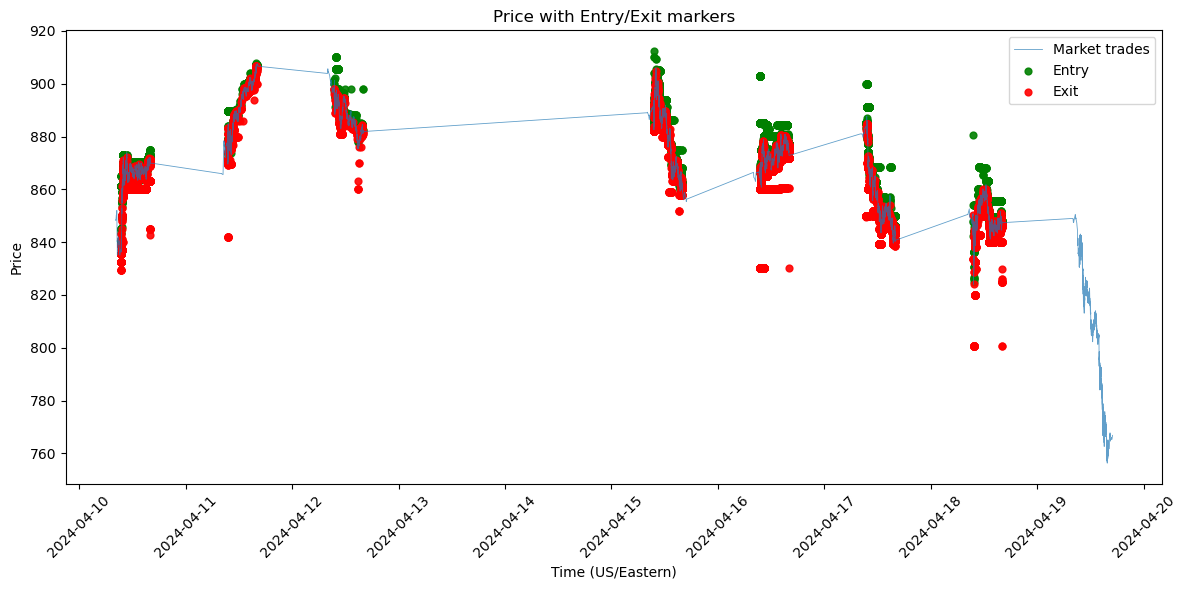

In [9]:
trade_log = df.copy()
trade_log["EntryTime_utc"] = pd.to_datetime(trade_log["EntryTime"], utc=True)
trade_log["ExitTime_utc"] = pd.to_datetime(trade_log["ExitTime"], utc=True)
trade_log["EntryTime_et"] = trade_log["EntryTime_utc"].dt.tz_convert(ZoneInfo("America/New_York"))
trade_log["ExitTime_et"] = trade_log["ExitTime_utc"].dt.tz_convert(ZoneInfo("America/New_York"))

plt.figure(figsize=(12, 6))
plt.plot(trade_df["time_et"], trade_df["price"], linewidth=0.6, alpha=0.7, label="Market trades")
plt.scatter(trade_log["EntryTime_et"], trade_log["EntryPrice"], color="green", s=24, label="Entry", alpha=0.9)
plt.scatter(trade_log["ExitTime_et"], trade_log["ExitPrice"], color="red", s=24, label="Exit", alpha=0.9)
plt.xlabel("Time (US/Eastern)")
plt.ylabel("Price")
plt.title("Price with Entry/Exit markers")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Get the frequency of when we entered trades based on time of day

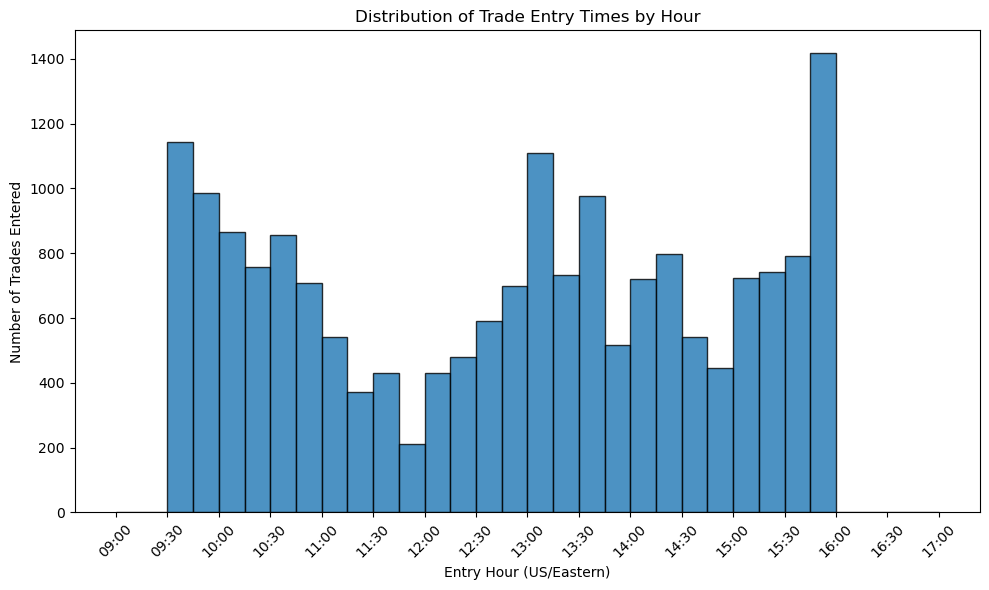

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract hour and minute as float (e.g., 10:30 --> 10.5)
trade_log["EntryHourFloat"] = trade_log["EntryTime_et"].dt.hour + trade_log["EntryTime_et"].dt.minute / 60.0

# Define bins with partial (fractional) tick sizes
bin_width = 0.25  # 15-min bins (0.25 hour)
bins = np.arange(9, 17 + bin_width, bin_width)

plt.figure(figsize=(10,6))
plt.hist(trade_log["EntryHourFloat"], bins=bins, edgecolor='black', alpha=0.8)

plt.xlabel("Entry Hour (US/Eastern)")
plt.ylabel("Number of Trades Entered")
plt.title("Distribution of Trade Entry Times by Hour")

# Set ticks at desired interval (e.g., every 0.5 hour)
tick_locs = np.arange(9, 17+0.01, 0.5)
tick_labels = [f"{int(h):02d}:{int((h%1)*60):02d}" for h in tick_locs]
plt.xticks(tick_locs, tick_labels, rotation=45)

plt.tight_layout()
plt.show()


Other misc stats about our strategy. We ran the strategy with these parameters:
- n, number of levels in the order book to track: 8
- t: entry threshold for order book imbalance: 0.5
- exit_threshold: 0
- l: persistence length: 20
- w: weight exponent: 1.0
- a: round trip latency: 0.0 (this is at 0 nanosecond latency, not realistic to real world conditions!)

In [27]:
print(f"We made {len(df)} trades")
print(f"Our win rate(number of winning trades / total trades * 100%) was {len(df[df['ExitPrice'] > df['EntryPrice']]) / len(df) * 100}%")
print(f"Our average trade duration/holding period/position time was {(trade_log["ExitTime_et"] - trade_log["EntryTime_et"]).mean()}")


We made 18583 trades
Our win rate(number of winning trades / total trades * 100%) was 0.08071893666254103%
Our average trade duration/holding period/position time was 0 days 00:00:09.181621880


In [16]:
trade_log

,StrategyName,Symbol,TradeID,EntryPrice,ExitPrice,Quantity,RealizedPL,State,EntryTime,ExitTime,EntryTime_utc,ExitTime_utc,EntryTime_et,ExitTime_et
0,Test,NVDA,6430735647606046720,865.2268,829.280224,100,-3594.657632,TRADE_STATE_CLOSED,2024-Apr-10 13:30:01.014573,2024-Apr-10 13:30:01.065556,2024-04-10 13:30:01.014573+00:00,2024-04-10 13:30:01.065556+00:00,2024-04-10 09:30:01.014573-04:00,2024-04-10 09:30:01.065556-04:00
1,Test,NVDA,6430735647606046820,865.2268,829.280224,100,-3594.657632,TRADE_STATE_CLOSED,2024-Apr-10 13:30:01.076414,2024-Apr-10 13:30:01.101591,2024-04-10 13:30:01.076414+00:00,2024-04-10 13:30:01.101591+00:00,2024-04-10 09:30:01.076414-04:00,2024-04-10 09:30:01.101591-04:00
2,Test,NVDA,6430735647606046920,865.2268,829.361922,100,-3586.487815,TRADE_STATE_CLOSED,2024-Apr-10 13:30:01.122738,2024-Apr-10 13:30:01.132211,2024-04-10 13:30:01.122738+00:00,2024-04-10 13:30:01.132211+00:00,2024-04-10 09:30:01.122738-04:00,2024-04-10 09:30:01.132211-04:00
3,Test,NVDA,6430735647606047003,865.1532,829.361922,100,-3579.127815,TRADE_STATE_CLOSED,2024-Apr-10 13:30:01.163320,2024-Apr-10 13:30:01.180122,2024-04-10 13:30:01.163320+00:00,2024-04-10 13:30:01.180122+00:00,2024-04-10 09:30:01.163320-04:00,2024-04-10 09:30:01.180122-04:00
4,Test,NVDA,6430735647606047071,865.1532,829.361922,100,-3579.127815,TRADE_STATE_CLOSED,2024-Apr-10 13:30:01.378767,2024-Apr-10 13:30:01.471862,2024-04-10 13:30:01.378767+00:00,2024-04-10 13:30:01.471862+00:00,2024-04-10 09:30:01.378767-04:00,2024-04-10 09:30:01.471862-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18578,Test,NVDA,6430735647606169880,847.3742,824.968820,100,-2240.537974,TRADE_STATE_CLOSED,2024-Apr-18 19:59:50.843459,2024-Apr-18 19:59:51.035284,2024-04-18 19:59:50.843459+00:00,2024-04-18 19:59:51.035284+00:00,2024-04-18 15:59:50.843459-04:00,2024-04-18 15:59:51.035284-04:00
18579,Test,NVDA,6430735647606169887,847.3743,824.968820,100,-2240.547974,TRADE_STATE_CLOSED,2024-Apr-18 19:59:51.169295,2024-Apr-18 19:59:52.036087,2024-04-18 19:59:51.169295+00:00,2024-04-18 19:59:52.036087+00:00,2024-04-18 15:59:51.169295-04:00,2024-04-18 15:59:52.036087-04:00
18580,Test,NVDA,6430735647606169894,847.9823,800.577967,100,-4740.433338,TRADE_STATE_CLOSED,2024-Apr-18 19:59:55.838740,2024-Apr-18 19:59:55.840219,2024-04-18 19:59:55.838740+00:00,2024-04-18 19:59:55.840219+00:00,2024-04-18 15:59:55.838740-04:00,2024-04-18 15:59:55.840219-04:00
18581,Test,NVDA,6430735647606169901,847.1912,846.739833,100,-45.136742,TRADE_STATE_CLOSED,2024-Apr-18 19:59:56.005069,2024-Apr-18 19:59:56.048908,2024-04-18 19:59:56.005069+00:00,2024-04-18 19:59:56.048908+00:00,2024-04-18 15:59:56.005069-04:00,2024-04-18 15:59:56.048908-04:00
